In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Flatten, MaxPooling2D, Input, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D, Rescaling, Lambda
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras.regularizers import l2

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
 tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
batch_size = 32
image_size = (128,128)

train_path = 'train'
validation_path = 'val'
test_path = 'test'

def datagen_function(path, aug=False):
    if aug == True:
        generator = ImageDataGenerator(
            rescale = 1 / 128.0,
            rotation_range = 15,
            width_shift_range = 0.15,
            height_shift_range = 0.15,
            shear_range = 0.15,
            zoom_range = 0.15,
            horizontal_flip = True,
            fill_mode = 'nearest',
            preprocessing_function = preprocess_input
        )
    else:
        generator = ImageDataGenerator(
            rescale = 1 / 128.0,
            preprocessing_function = preprocess_input
        )
    return generator.flow_from_directory(
        path,
        target_size = image_size,
        shuffle = True,
        class_mode = 'categorical',
        batch_size = batch_size
    )
train_gen = datagen_function(train_path, True)
validation_gen = datagen_function(validation_path)
test_gen = datagen_function(test_path)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [5]:
images, labels = next(train_gen)
images[0]

array([[[ 0.30516404,  0.20485157,  0.1509375 ],
        [ 0.30516404,  0.20485157,  0.1509375 ],
        [ 0.30516404,  0.20485157,  0.1509375 ],
        ...,
        [-0.33546096, -0.43577343, -0.4896875 ],
        [-0.33546096, -0.43577343, -0.4896875 ],
        [-0.5714216 , -0.6717341 , -0.72564816]],

       [[ 0.30516404,  0.20485157,  0.1509375 ],
        [ 0.30516404,  0.20485157,  0.1509375 ],
        [ 0.30516404,  0.20485157,  0.1509375 ],
        ...,
        [-0.33546096, -0.43577343, -0.4896875 ],
        [-0.33546096, -0.43577343, -0.4896875 ],
        [-0.58266646, -0.6829789 , -0.736893  ]],

       [[ 0.30516404,  0.20485157,  0.1509375 ],
        [ 0.30516404,  0.20485157,  0.1509375 ],
        [ 0.30516404,  0.20485157,  0.1509375 ],
        ...,
        [-0.33546096, -0.43577343, -0.4896875 ],
        [-0.33546096, -0.43577343, -0.4896875 ],
        [-0.59391135, -0.6942238 , -0.7481379 ]],

       ...,

       [[ 1.0950668 ,  0.9947544 ,  0.9408403 ],
        [ 1

In [6]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# base_model.trainable = False

model = base_model.output
model = BatchNormalization()(model)
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2048, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(1024, activation='relu')(model)
model = Dense(7, activation='softmax')(model)

model = Model(inputs = base_model.input, outputs = model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, min_lr = 1e-7, patience = 4, verbose = 0)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience = 7, verbose = 0)
model_checkpoint = ModelCheckpoint('checkpoints/resnet_best.h5', save_best_only=True, monitor='val_acc', mode='max')
csv_logger = CSVLogger('resnet50.log')

model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = 'acc')
history = model.fit(train_gen,validation_data = validation_gen, epochs = 50, callbacks = [early_stopping, reduce_lr, model_checkpoint, csv_logger])

Epoch 1/50
898/898 [==============================] - 139s 145ms/step - loss: 1.3934 - acc: 0.4665 - val_loss: 1.1769 - val_acc: 0.5508 - lr: 1.0000e-04
Epoch 2/50
898/898 [==============================] - 128s 142ms/step - loss: 1.1293 - acc: 0.5750 - val_loss: 1.1477 - val_acc: 0.5784 - lr: 1.0000e-04
Epoch 3/50
898/898 [==============================] - 126s 140ms/step - loss: 1.0385 - acc: 0.6159 - val_loss: 1.0035 - val_acc: 0.6239 - lr: 1.0000e-04
Epoch 4/50
898/898 [==============================] - 128s 142ms/step - loss: 0.9773 - acc: 0.6344 - val_loss: 0.9758 - val_acc: 0.6328 - lr: 1.0000e-04
Epoch 5/50
898/898 [==============================] - 129s 144ms/step - loss: 0.9396 - acc: 0.6545 - val_loss: 1.0090 - val_acc: 0.6286 - lr: 1.0000e-04
Epoch 6/50
898/898 [==============================] - 135s 150ms/step - loss: 0.9075 - acc: 0.6612 - val_loss: 0.9708 - val_acc: 0.6339 - lr: 1.0000e-04
Epoch 7/50
898/898 [==============================] - 129s 144ms/step - loss: 0.87

In [8]:
model_best = load_model("checkpoints/resnet_best.h5")
model_best.evaluate(test_gen)

113/113 [==============================] - 5s 31ms/step - loss: 0.9533 - acc: 0.6980


[0.9532853364944458, 0.6979659795761108]

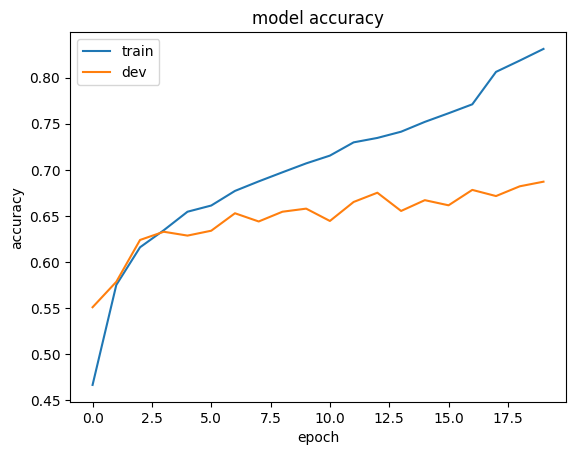

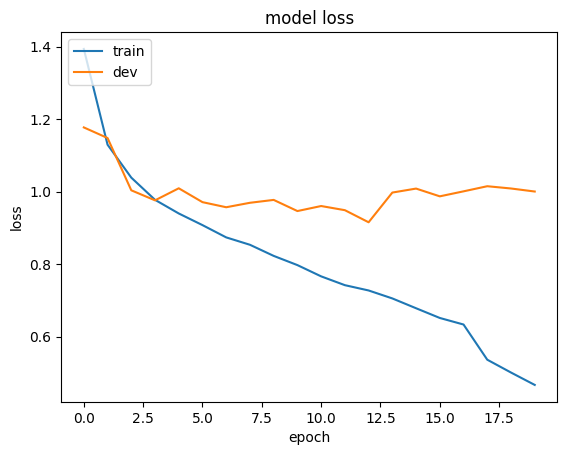

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()